# Interpolation Calanus multivariate
Interpolate (multivariate) the observations of _Calanus finmarchicus_ and _Calanus helgolandicus_, using the water temperature as a co-variable.

The fields are prepared over a region covering the Northeast Atlantic.      
Different resolutions are tested: 0.5° X 0.5°, 1° X 1° and 2° X 2°.

In order to modify the directories, the spatial resolution, edit the configuration file [config.jl](../src/config.jl).

## Procedure

The steps are:
- reading the data
- preparting the land/sea mask
- setting the analysis parameters
- perform the interpolation

In [1]:
using Dates
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot
using PyCall
include("../src/InterpCalanus.jl")
include("../src/config.jl")
@show pathof(DIVAnd)

pathof(DIVAnd) = "/home/ctroupin/.julia/packages/DIVAnd/MV3j9/src/DIVAnd.jl"


[ Info: Workig at resoluton 0.25° X 0.25°
[ Info: Observation file already downloaded
[ Info: Bathymetry file already downloaded
[ Info: Temperature file already downloaded


"/home/ctroupin/.julia/packages/DIVAnd/MV3j9/src/DIVAnd.jl"

## Files and directories
We need to have:
1. the temperature data
2. the CPR observations
3. the bathymetry.

The file `temperature_surface_WOD2.nc` contains all the temperature measurements in the region of interest and for a depth between 5 m and the sea surface. It was prepared with the notebook [`read_plot_WOD_data`](read_plot_WOD_data.ipynb).

## Domain, metrics, mask

In [2]:
longrid = domain[1]:dlon:domain[2]
latgrid = domain[3]:dlat:domain[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

[ Info: Size of the grid: 130 X 104
[ Info: (130, 104)


### Mask

In [3]:
_, _, mask = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, 5.0);

# Remove Med Sea
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

## Read the data
We will prepare monthly fields for given time periods.

In [4]:
yearmin = 2001
yearmax = 2001
imonth = 4

4

### Temperature

In [5]:
@time obsvalue, obslon, obslat, obsdepth, obstime, obsids = loadobs(Float64, temperaturefile, "Temperature");
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);
goodyear = (year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& (month_temperature .== imonth)
@info("Found $(sum(goodyear)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

  0.871546 seconds (3.88 M allocations: 252.098 MiB, 4.73% gc time, 88.85% compilation time)


[ Info: Found 1015 observations for the period April 2001 - 2001


In [6]:
@time lonT, latT, depthT, timeT, dataT = obslon[goodyear], obslat[goodyear], obsdepth[goodyear], 
obstime[goodyear], obsvalue[goodyear];

  0.059119 seconds (112.18 k allocations: 5.806 MiB, 99.70% compilation time)


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


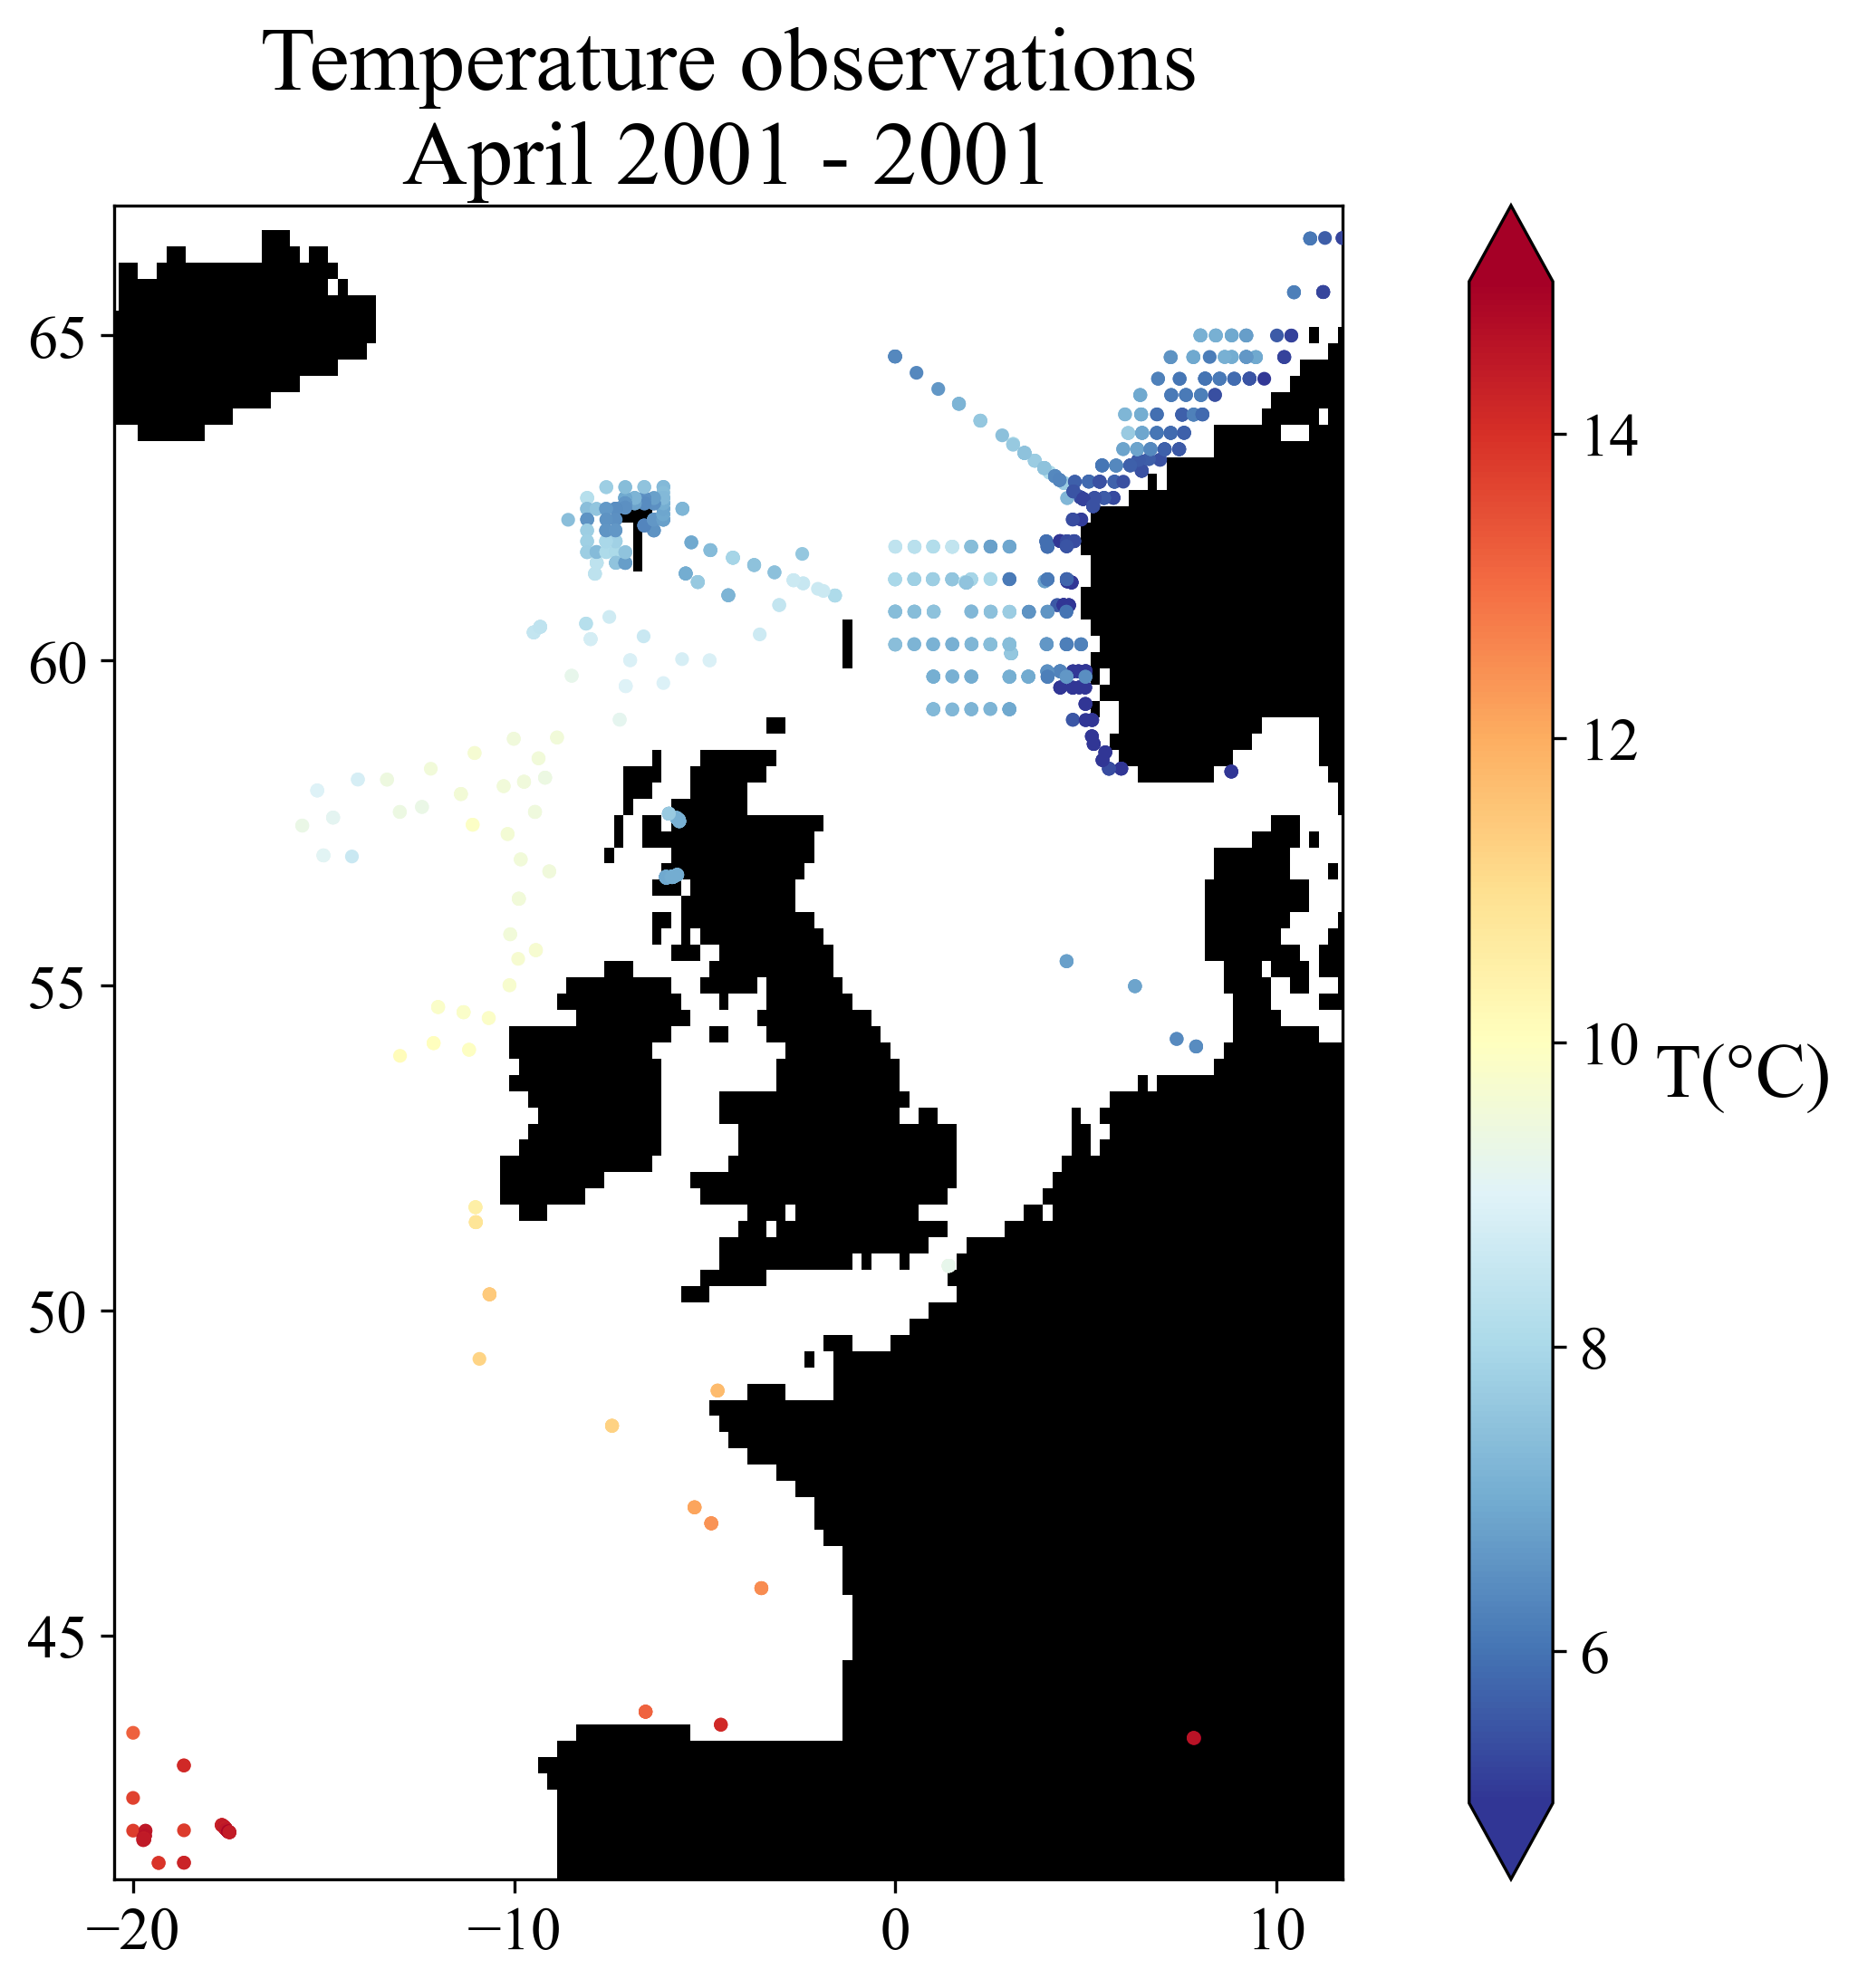

In [7]:
Tmin = 5.
Tmax = 15.

fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lonT, latT, s=7, c=dataT, cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="both")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb.set_label("T(°C)", rotation=0, ha="left")
ax.set_title("Temperature observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "WOD_temperature_200104"))
plt.show()

### Plankton

In [8]:
@time lon, lat, dates, calanus_finmarchicus, calanus_helgolandicus = InterpCalanus.read_data_calanus(datafile);

  0.858721 seconds (5.66 M allocations: 191.152 MiB, 5.72% gc time, 64.67% compilation time)


[ Info: (-20.447, 11.703)
[ Info: (41.2567, 66.808)


#### Subsetting

In [9]:
goodtimeCPR = (Dates.year.(dates) .>= yearmin ) .& (Dates.year.(dates) .<= yearmax) .& (Dates.month.(dates) .== imonth)
@info("Found plankton $(sum(goodtimeCPR)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

[ Info: Found plankton 261 observations for the period April 2001 - 2001


#### Make plot

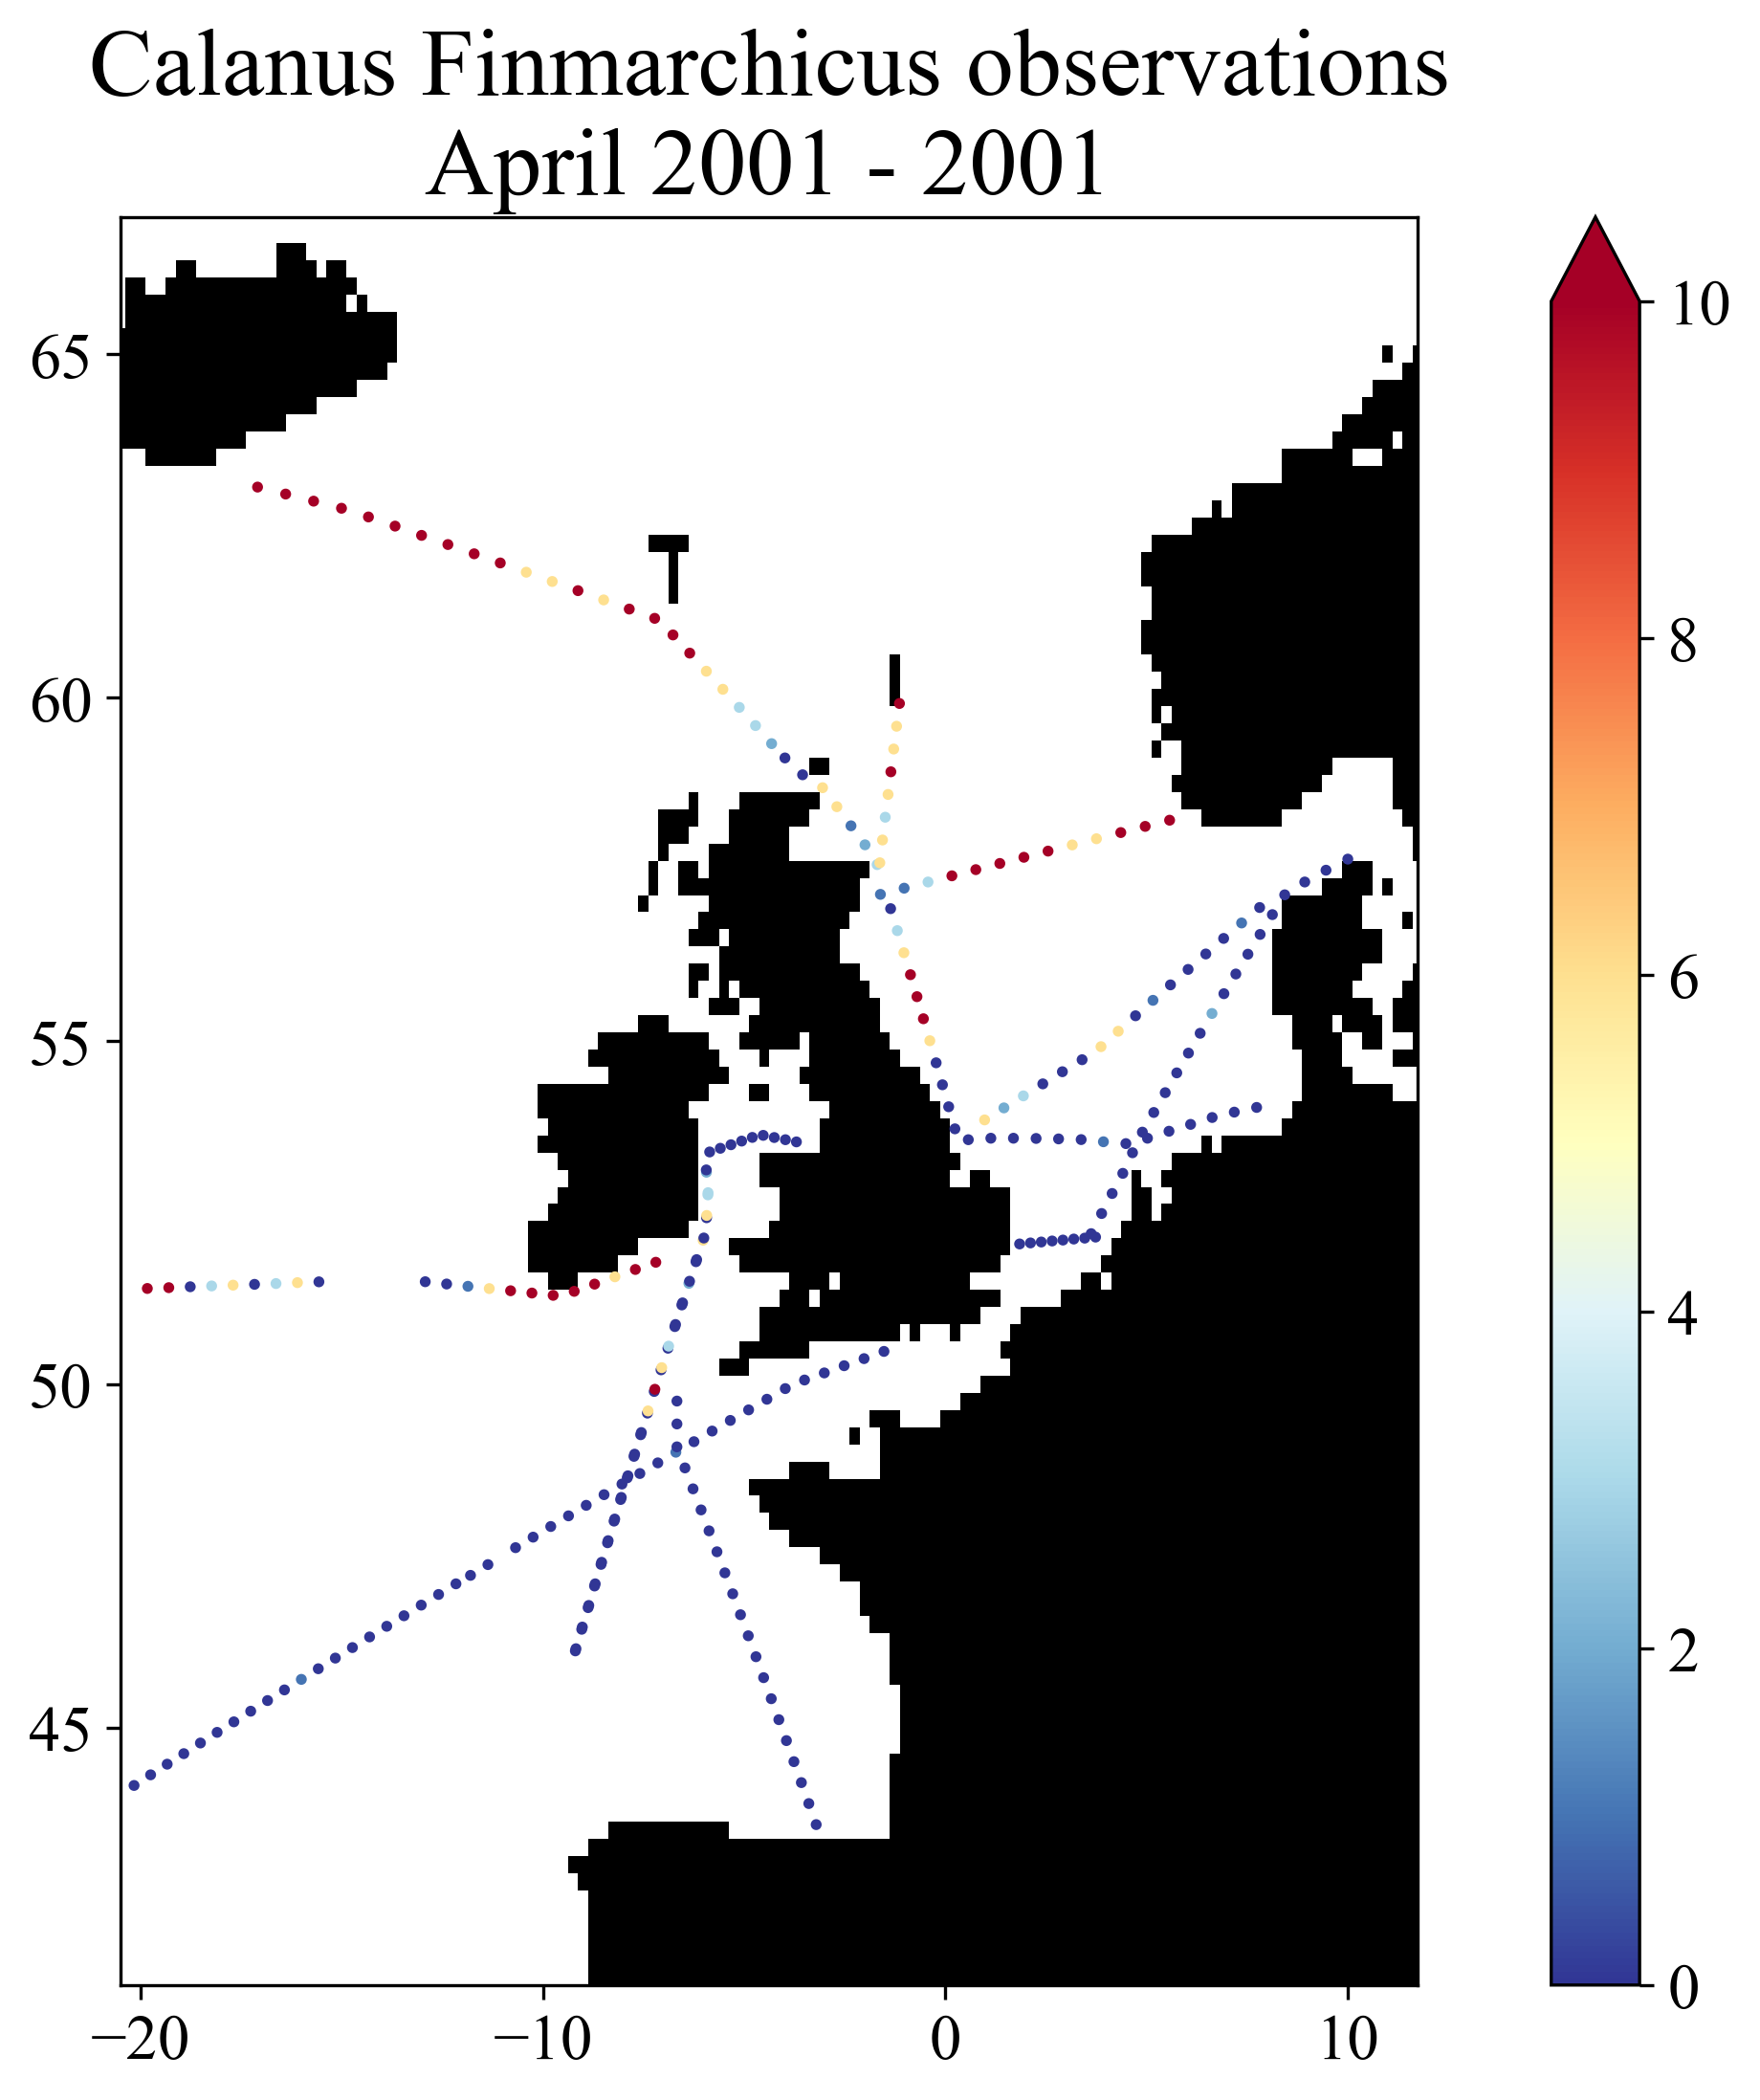

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_finmarchicus[goodtimeCPR], 
    cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Finmarchicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_finmarchicus_200104"))
plt.show()

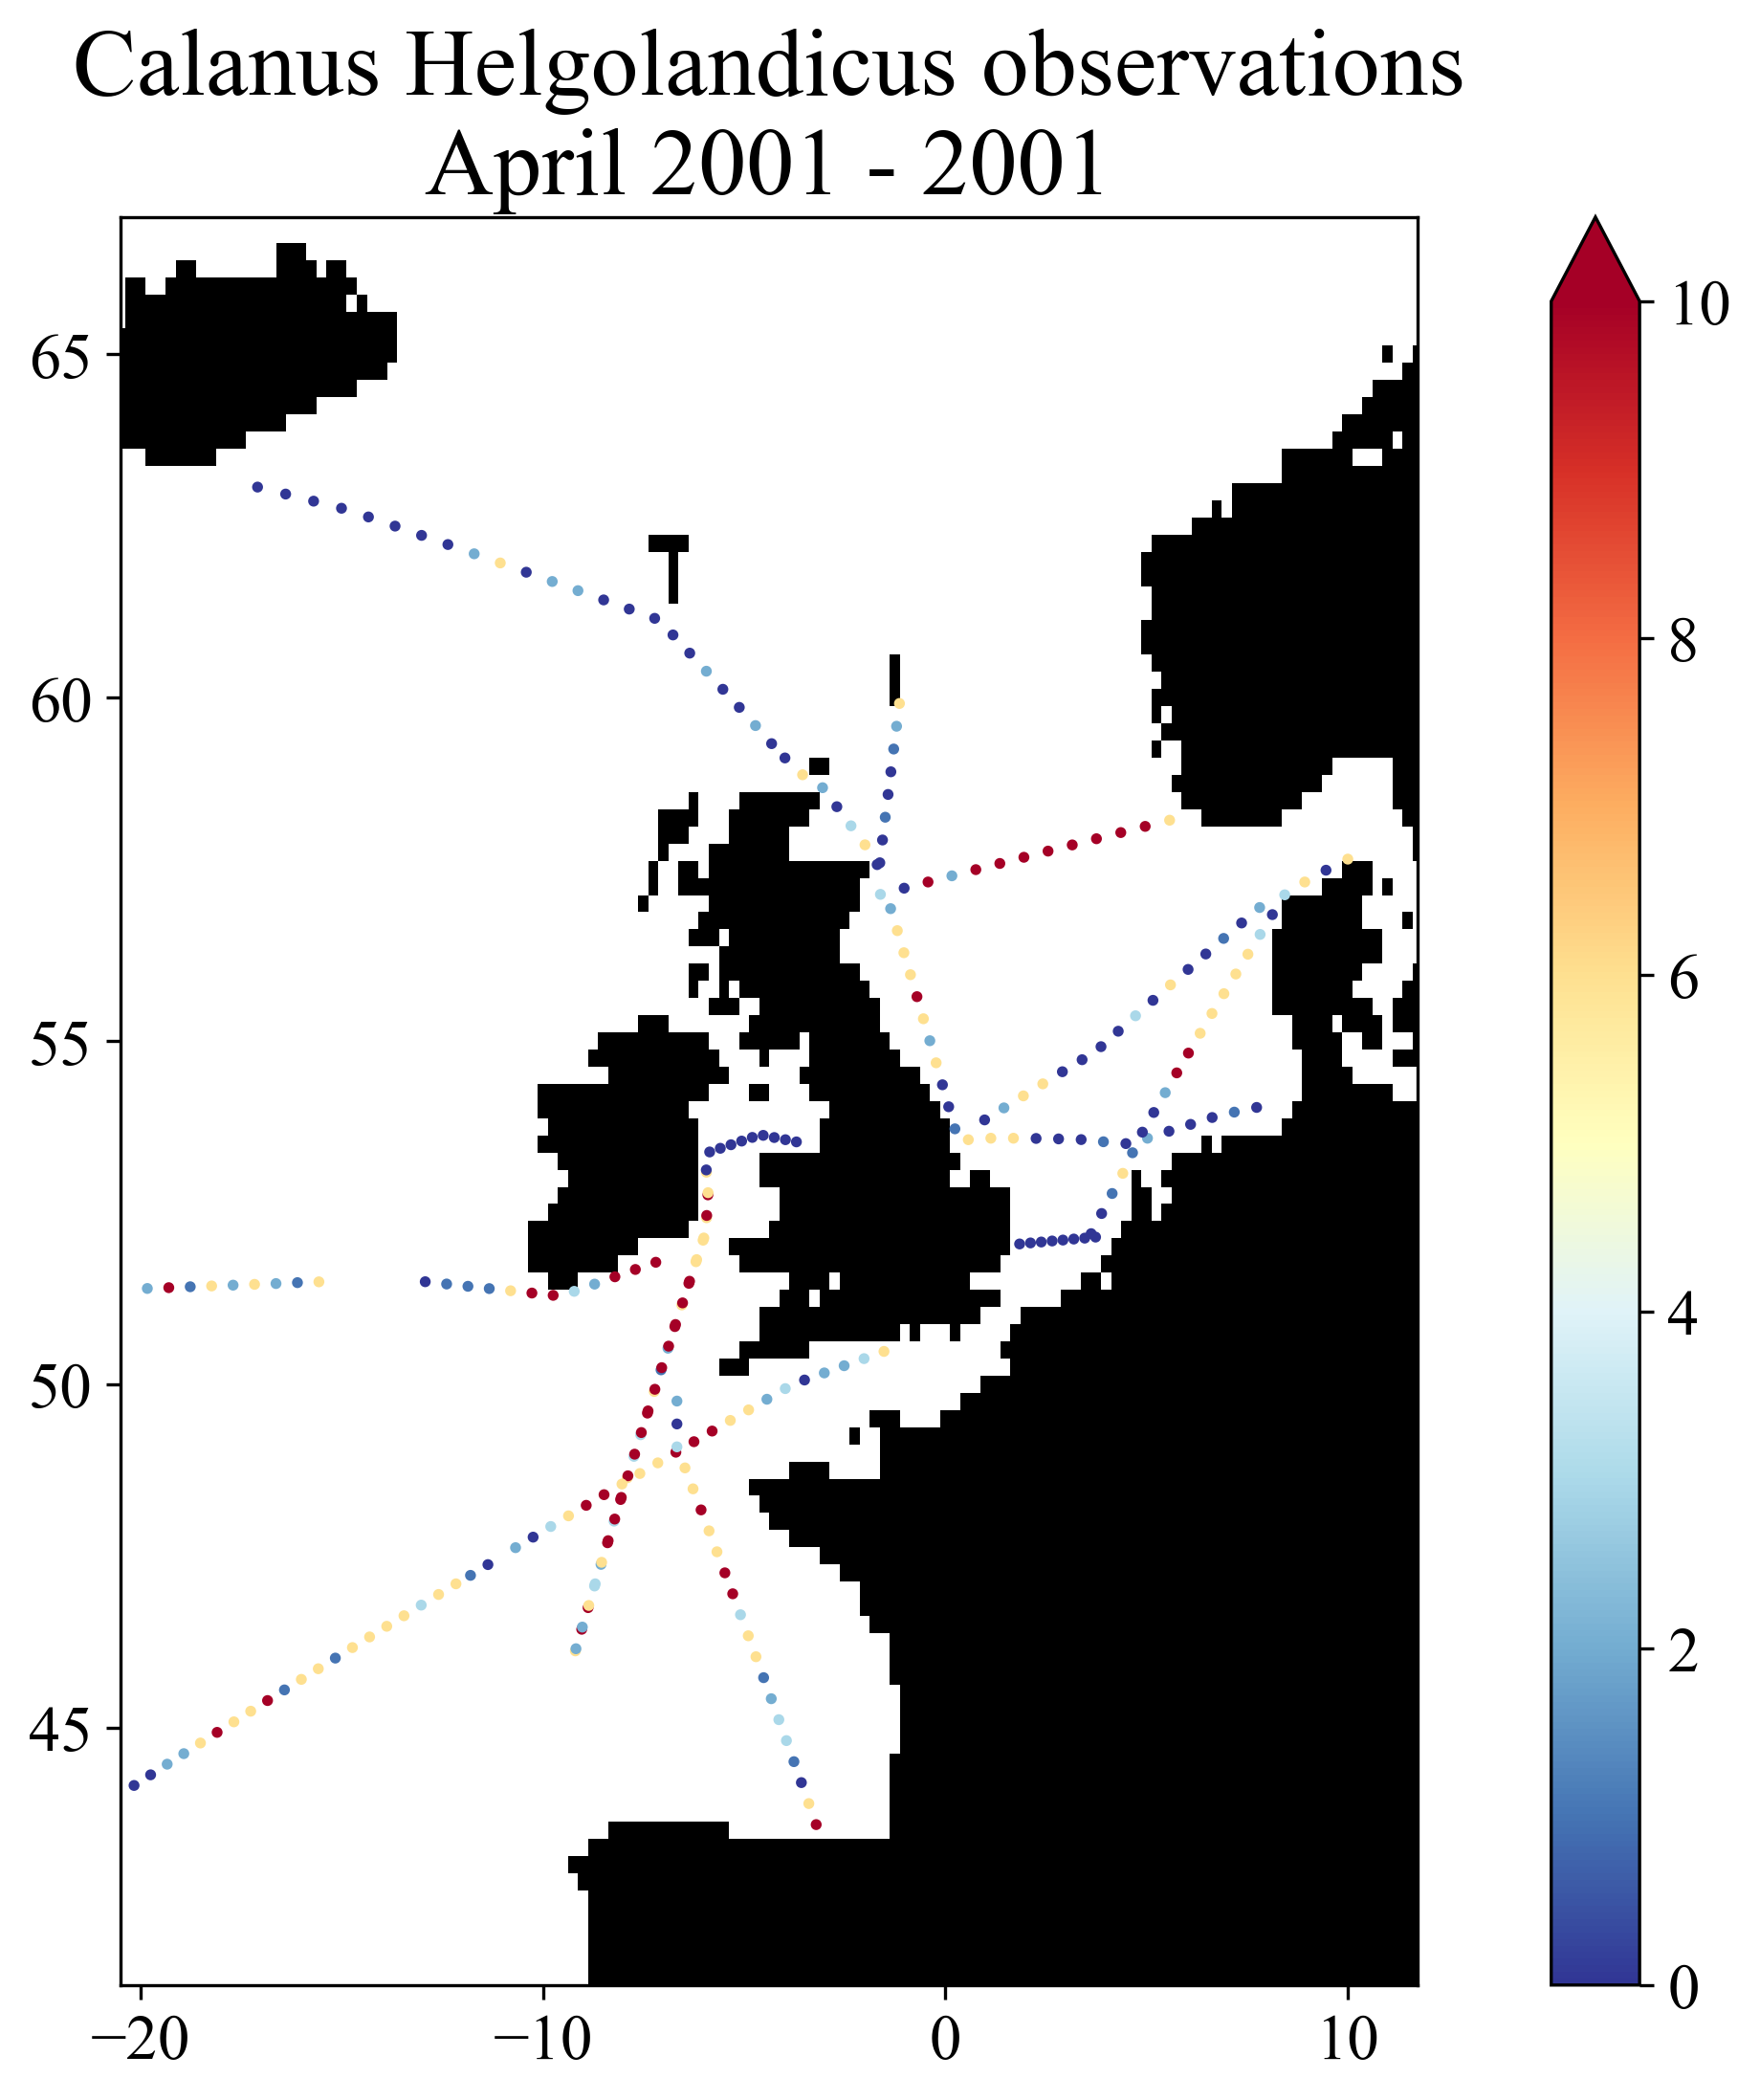

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_helgolandicus[goodtimeCPR], 
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Helgolandicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_helgolandicus_200104"))
plt.show()

## Univariate analysis
### Parameters

In [12]:
L = 2.5
epsilon2 = 5.

5.0

### Monovariate

In [13]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_finmarchicus[goodtimeCPR] .- 0. * mean(calanus_finmarchicus[goodtimeCPR]), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_helgolandicus[goodtimeCPR] .- 0. * mean(calanus_helgolandicus[goodtimeCPR]), (L, L), epsilon2);
@time T_interp, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lonT, latT), 
    dataT .- 1. * mean(dataT), (L, L), epsilon2);

 13.150787 seconds (44.51 M allocations: 2.406 GiB, 6.53% gc time, 98.91% compilation time)
  0.090168 seconds (30.03 k allocations: 119.894 MiB, 27.25% gc time, 25.28% compilation time)
  0.756884 seconds (2.06 M allocations: 212.698 MiB, 4.28% gc time, 94.34% compilation time)


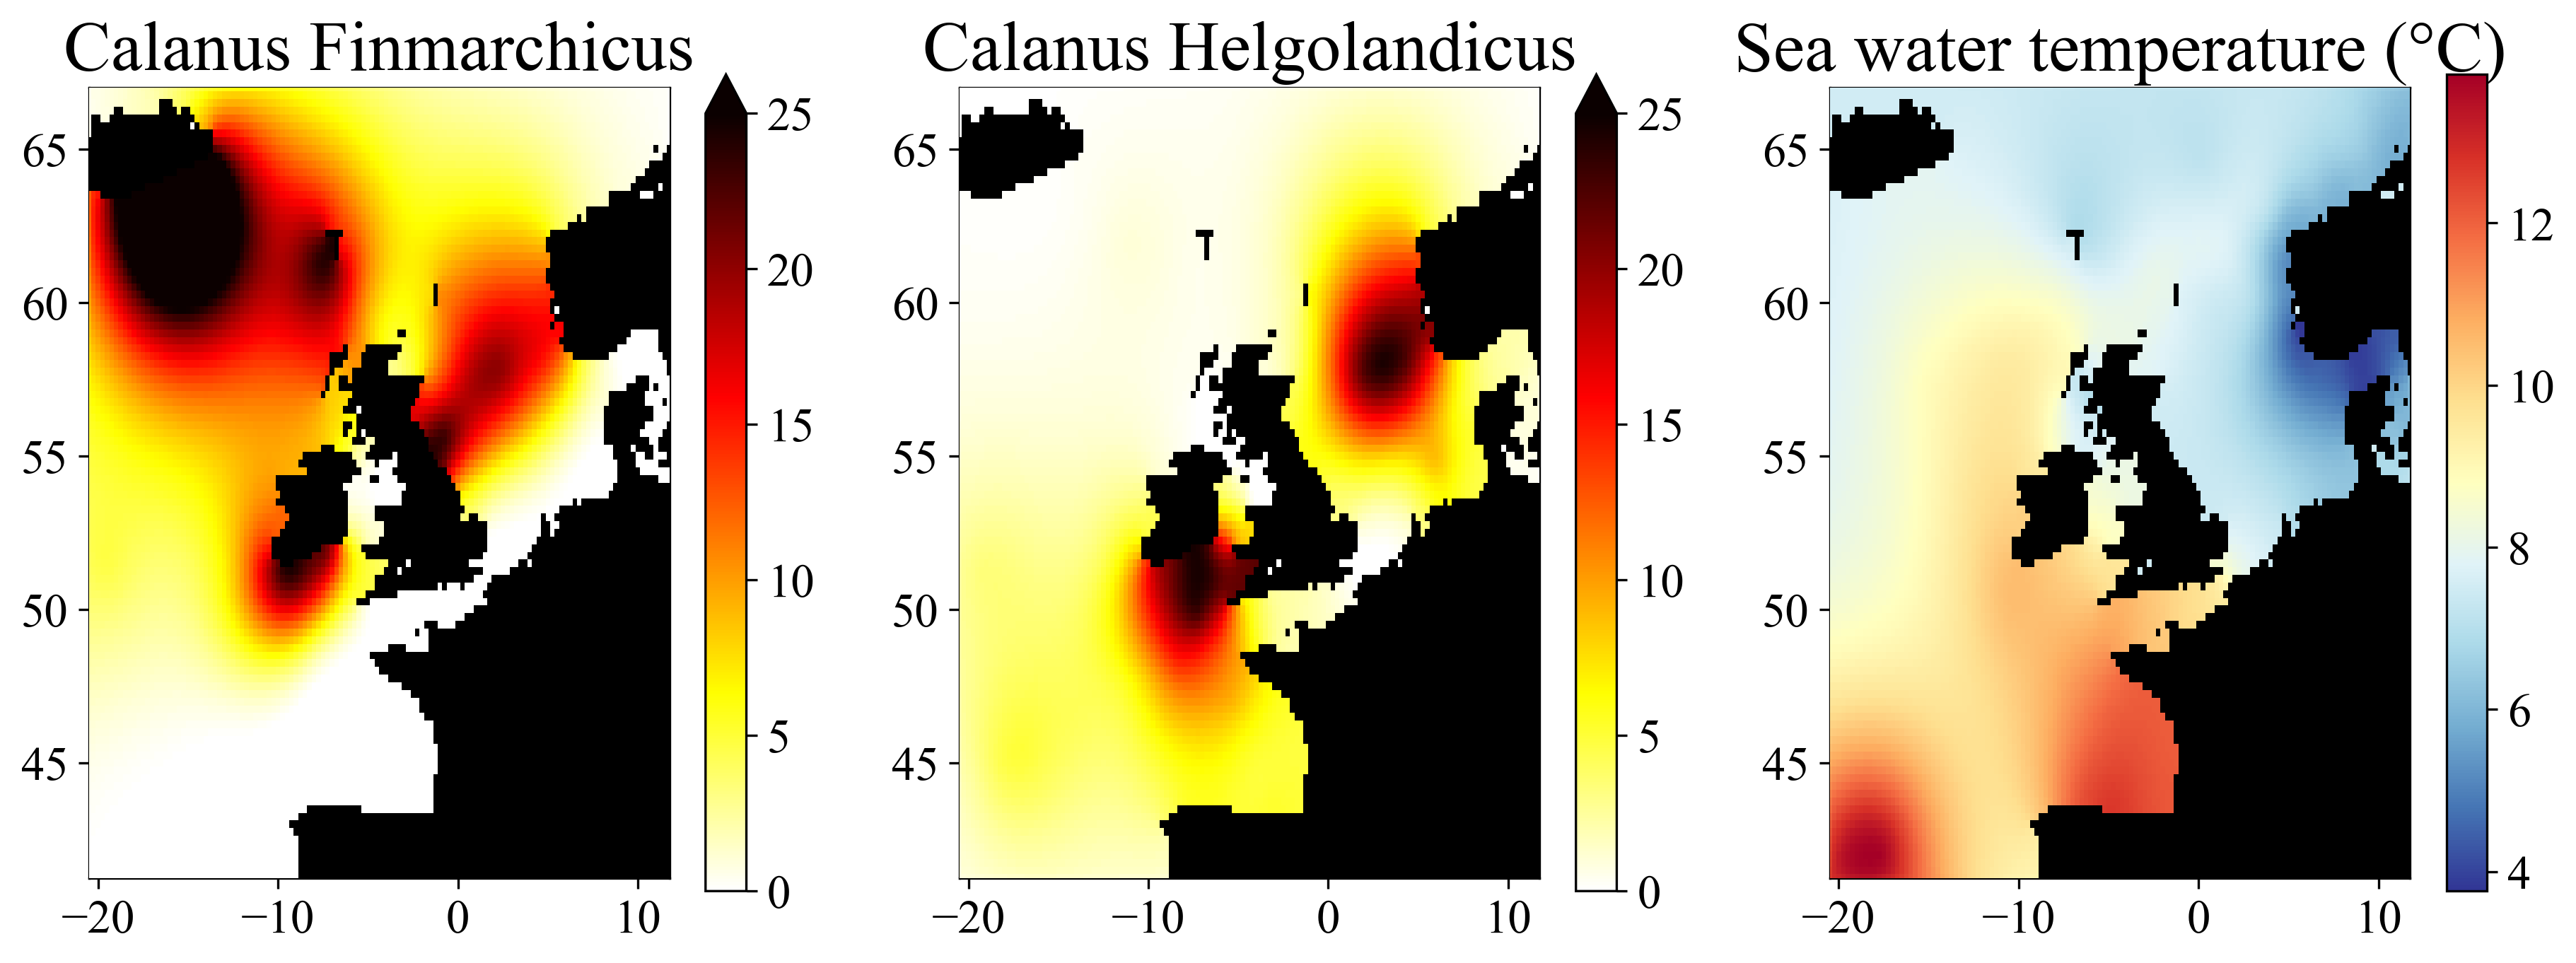

In [14]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi, yi, f_finmarchicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi, yi, f_helgolandicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi, yi, T_interp .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
plt.savefig(joinpath(figdir, "monovariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

## Multivariate analysis
### Data preparation
1. Concatenate all the coordinate and observation vectors
2. Normalise the variables
3. Create a new dimension `vvv` with value **1** for plankton data points and **2** for temperature observations.

In [16]:
function normalise_obs(obs)
    obsmean = mean(obs)
    obsstd = std(obs)
    obsnorm = (obs .- obsmean) ./ obsstd
    return obsnorm, obsmean, obsstd
end

function normalise_obs(obs, meanfact)
    obsmean = mean(obs)
    obsstd = std(obs)
    obsnorm = (obs .- meanfact .* obsmean) ./ obsstd
    return obsnorm, obsmean, obsstd
end

normalise_obs (generic function with 2 methods)

In [17]:
calanus_finmarchicus_norm, calanus_finmarchicus_mean, calanus_finmarchicus_std = 
normalise_obs(calanus_finmarchicus[goodtimeCPR], 0.);

calanus_helgolandicus_norm, calanus_helgolandicus_mean, calanus_helgolandicus_std = 
normalise_obs(calanus_helgolandicus[goodtimeCPR], 0.)
 
T_norm, T_mean, T_std = normalise_obs(dataT);

lonmulti = vcat(lon[goodtimeCPR], lonT)
latmulti = vcat(lat[goodtimeCPR], latT)
obsmulti_finmarchicus = vcat(calanus_finmarchicus_norm, T_norm)
obsmulti_helgolandicus = vcat(calanus_helgolandicus_norm, T_norm)
vvv = vcat(ones(length(findall(goodtimeCPR))), 2 * ones(length(lonT)));

### Create metrics and mask

In [19]:
maskmulti, (pm, pn, pv), (xi, yi, vi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid, 1:2);
maskmulti[:,:,1] = mask;
maskmulti[:,:,2] = mask;

### Perform analysis

In [21]:
@time fi1,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0), epsilon2);

@time fi2,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

  5.775919 seconds (19.29 M allocations: 1.229 GiB, 4.84% gc time, 96.98% compilation time)
  0.124188 seconds (26.93 k allocations: 287.374 MiB, 21.31% gc time)


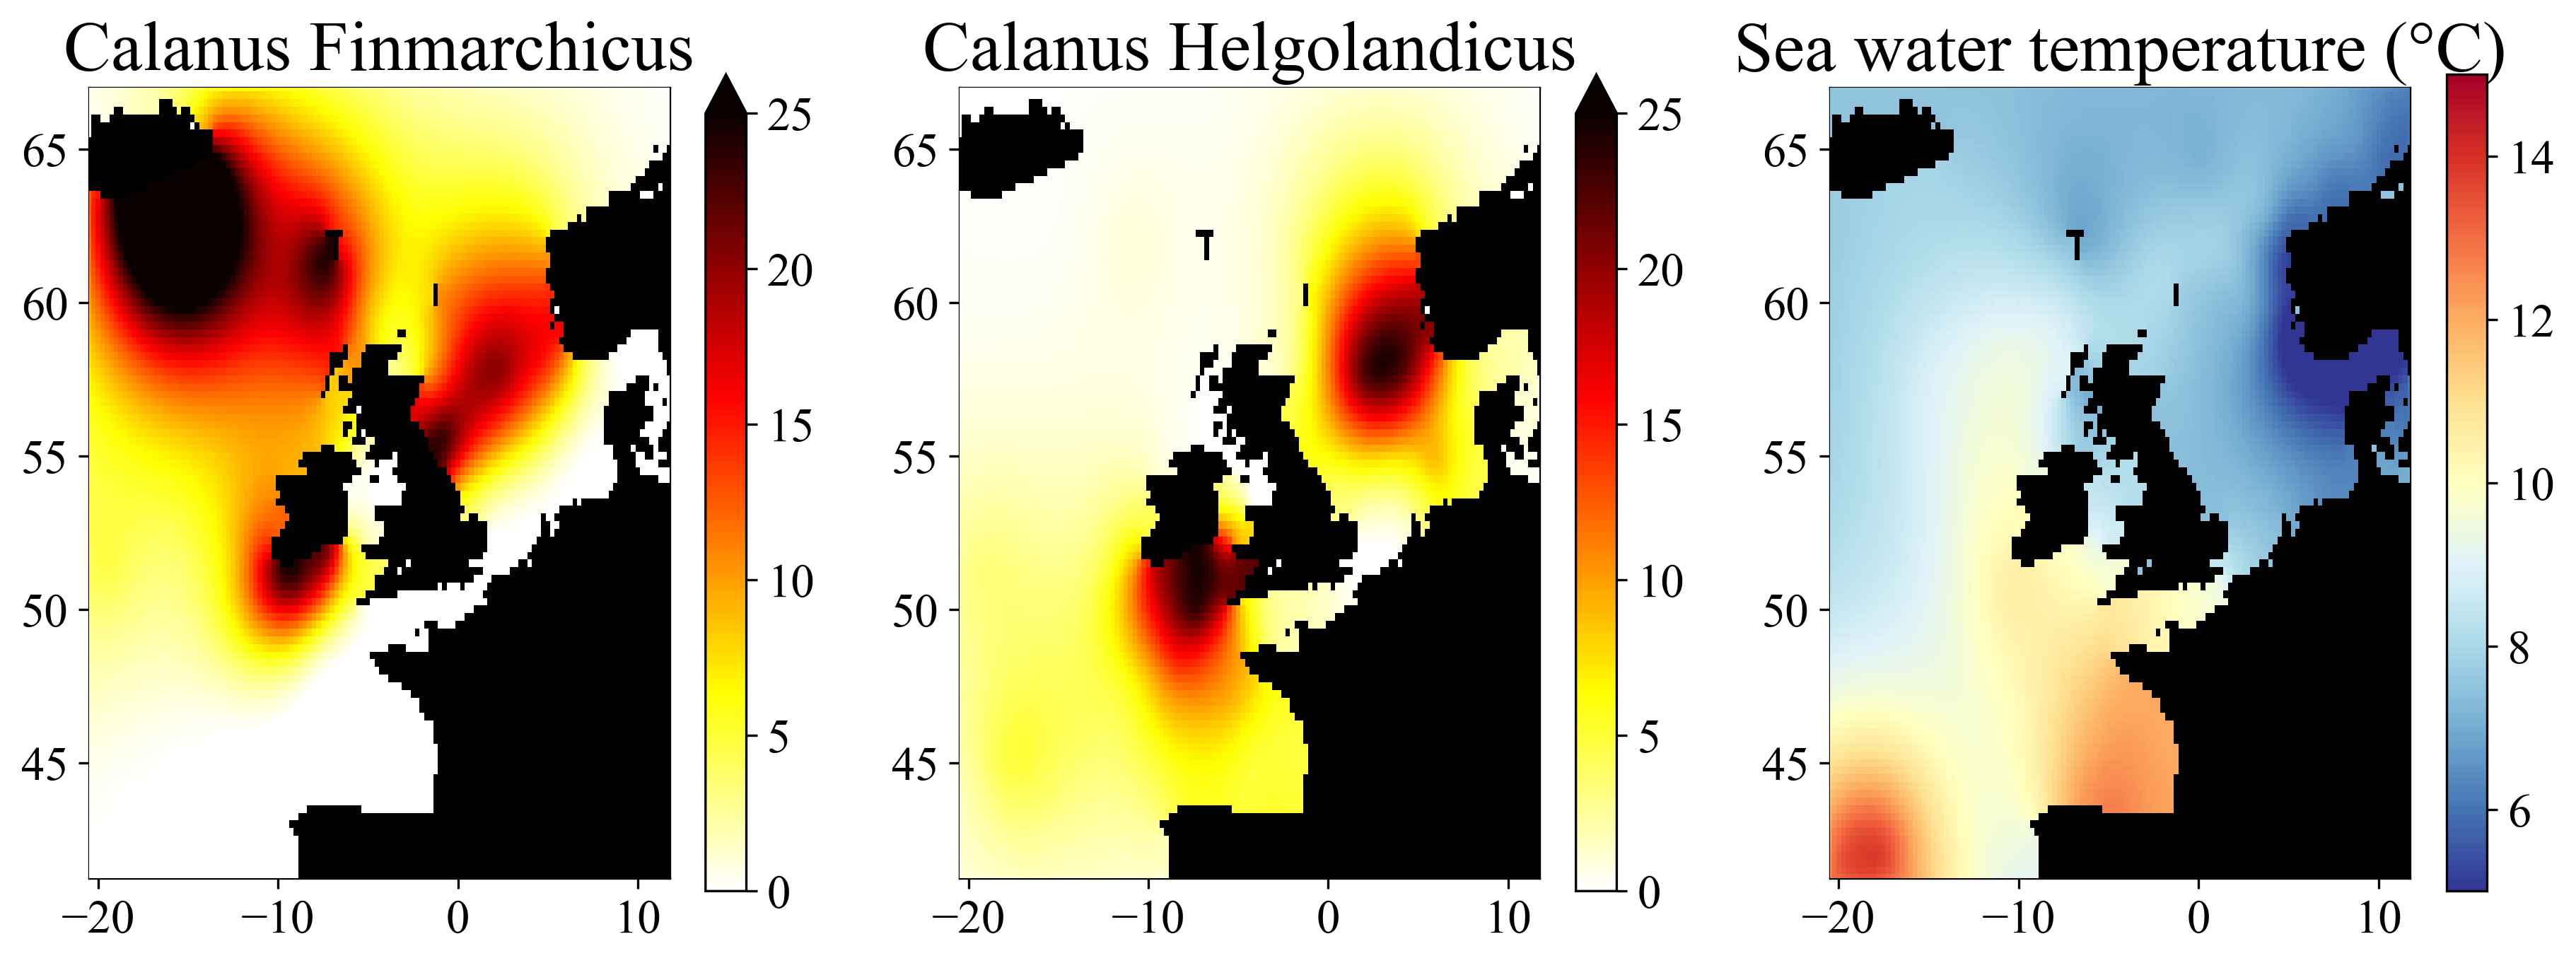

In [31]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fi1[:,:,1] .* calanus_finmarchicus_std) .+ 0. * calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fi2[:,:,1] .* calanus_helgolandicus_std) .+ 0. * calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1],
    (fi2[:,:,2] .* T_std) .+ T_mean, 
    cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

## Multivariate analysis
### EOF approach

In [25]:
@time fim1, s1, eof1, eofamplitudes1, emap1, emapm1 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 .*L), epsilon2);

@time fim2, s2, eof2, eofamplitudes2, emap2, emapm2 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 .*L), epsilon2);

 16.784924 seconds (57.95 M allocations: 5.023 GiB, 8.38% gc time, 94.59% compilation time)


#### Plot the gridded fields

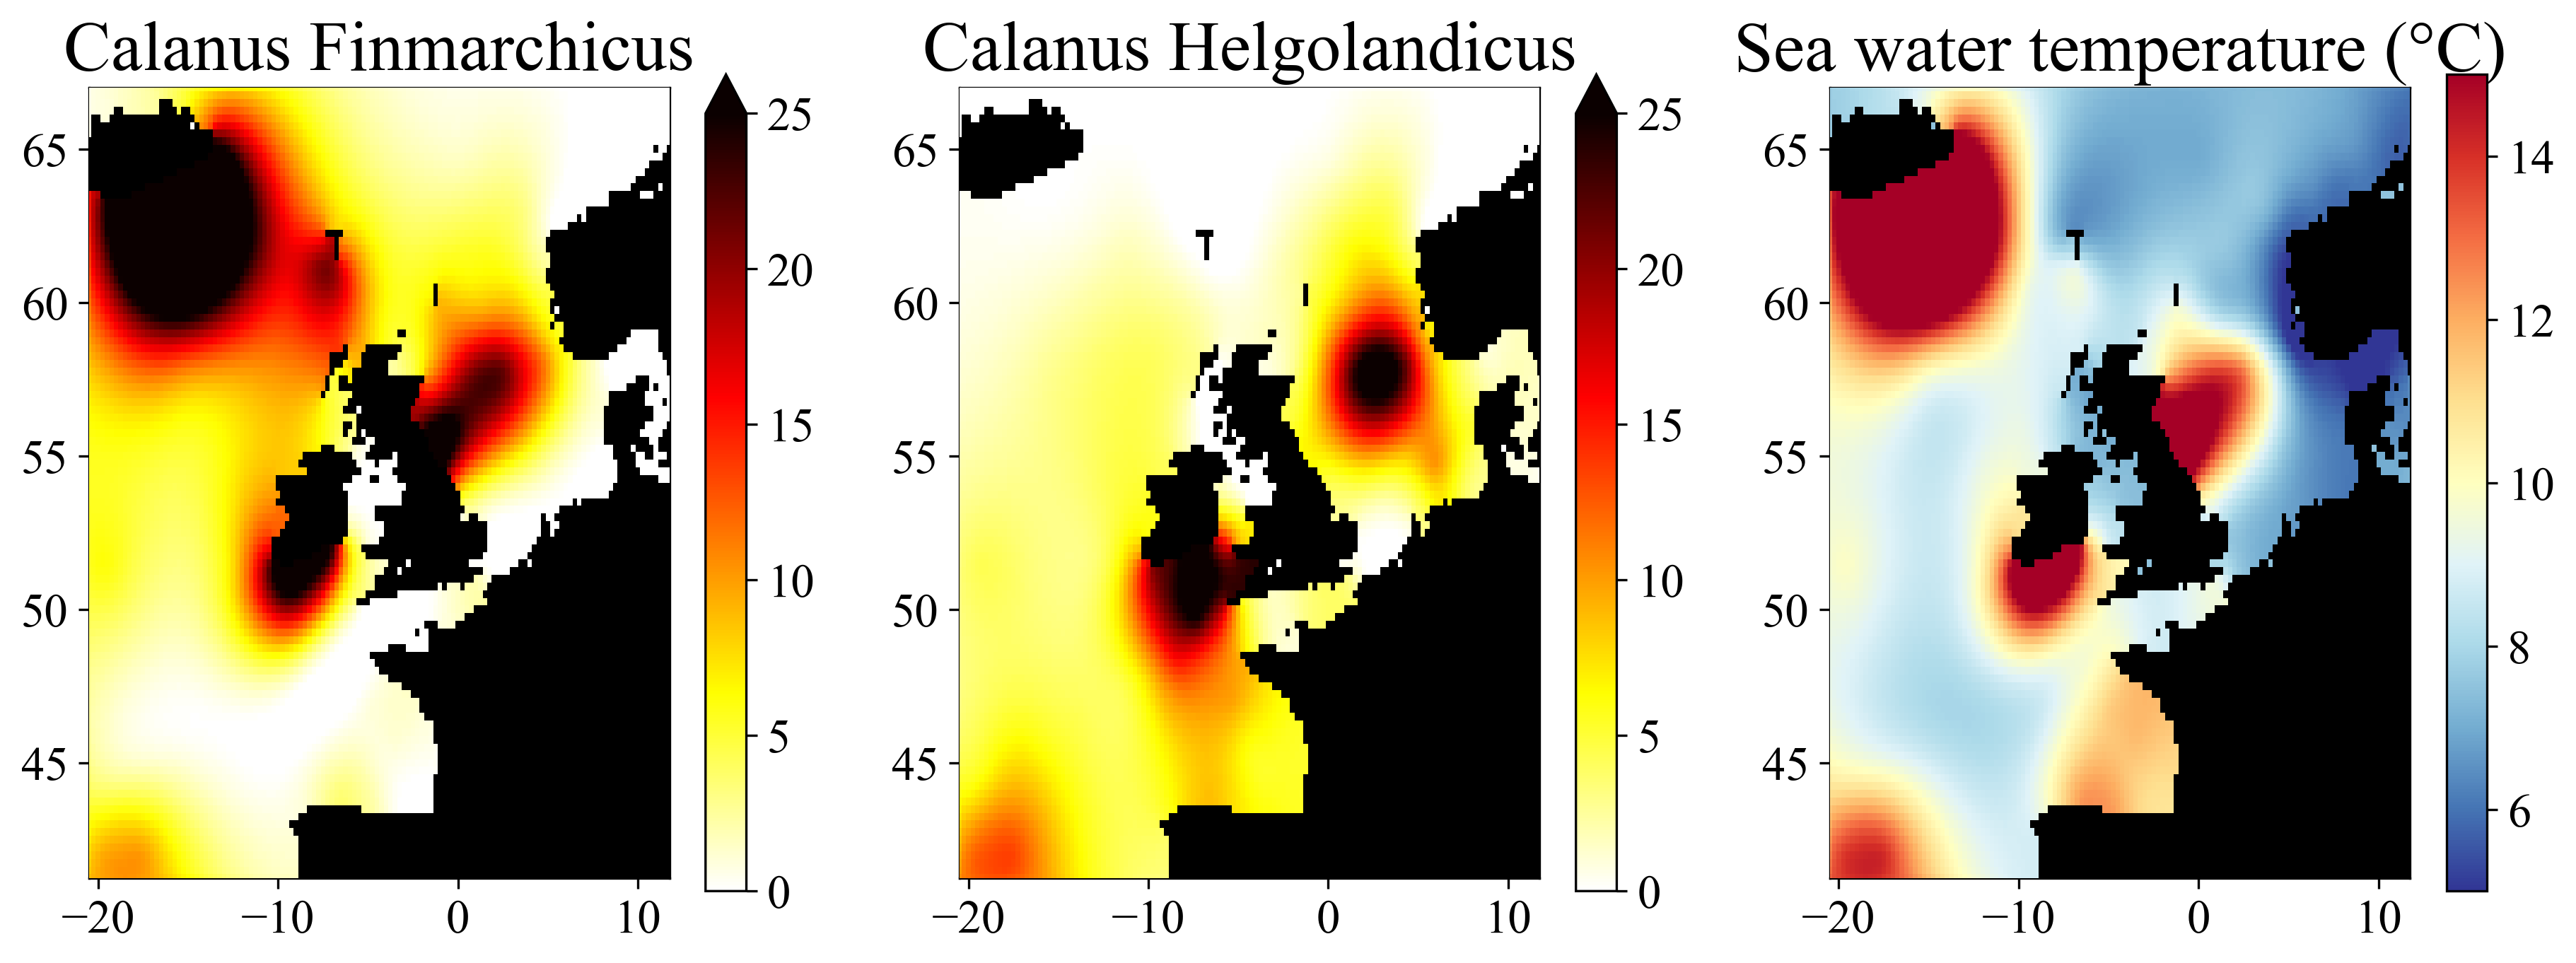

In [32]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1[:,:,1] .* calanus_finmarchicus_std) .+ 0. * calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2[:,:,1] .* calanus_helgolandicus_std) .+ 0. * calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1[:,:,2] .* T_std) .+ T_mean, cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm3)
plt.savefig(joinpath(figdir, "multivariate_eof.png"), dpi=300, bbox_inches="tight")

plt.show()

### Jacobian approach

In [33]:
@time fim1Jac, s1, emap1, emapm1, pv1 = DIVAnd_multivarJAC(maskmulti, 
    (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

@time fim2Jac, s2, emap2, emapm2, pv2 = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), 
    (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar cpme"
methm = "cpme"
  1.569319 seconds (1.37 M allocations: 2.779 GiB, 36.76% gc time)


In [81]:
size(emapm2)

(130, 104, 2)

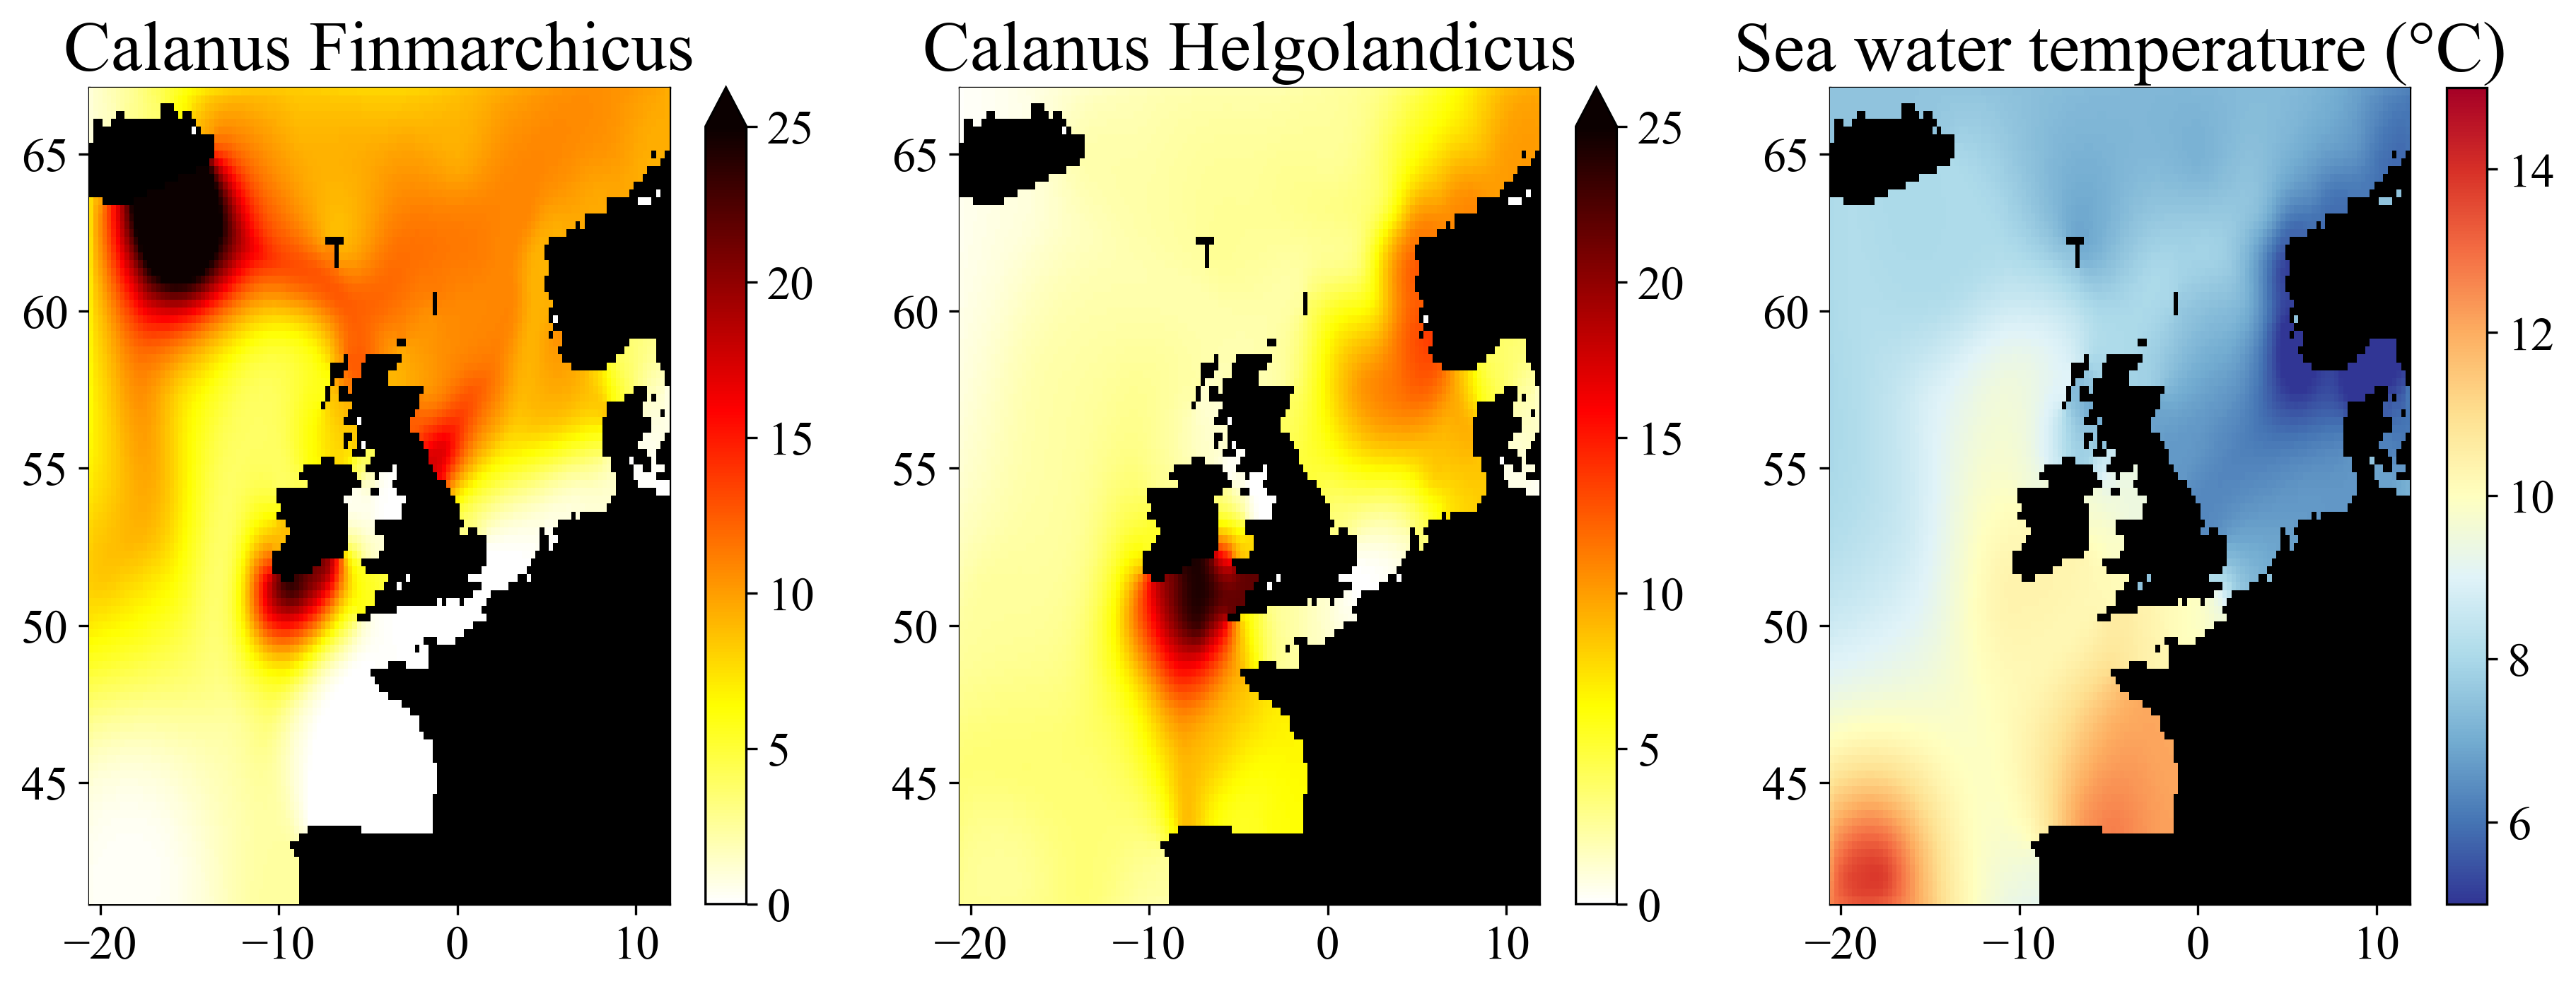

In [30]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1Jac[:,:,1] .* calanus_finmarchicus_std) .+ 0. * calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2Jac[:,:,1] .* calanus_helgolandicus_std) .+ 0. * calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1Jac[:,:,2] .* T_std) .+ T_mean, 
    cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate_jac.png"), dpi=300, bbox_inches="tight")


plt.show()

## Main loop

In [35]:
resdir

"../results/multivariate/025deg/"

In [79]:
resfilemonth1 = joinpath(resdir, "calanus_finmarchicus_year_month_multivariate_eof.nc")
resfilemonth2 = joinpath(resdir, "calanus_helgolandicus_year_month_multivariate_eof.nc")
resfilemonth3 = joinpath(resdir, "calanus_finmarchicus_year_month_multivariate_jacobian.nc")
resfilemonth4 = joinpath(resdir, "calanus_helgolandicus_year_month_multivariate_jacobian.nc")

InterpCalanus.create_nc_results_time(resfilemonth1, longrid, latgrid,  
                      "Calanus finmarchicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus finmarchicus",
                      domain=domain,
                      aphiaID=Int32(104464), L, epsilon2);

InterpCalanus.create_nc_results_time(resfilemonth2, longrid, latgrid,  
                      "Calanus helgolandicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus helgolandicus",
                      domain=domain,
                      aphiaID=Int32(104466), L, epsilon2);

InterpCalanus.create_nc_results_time(resfilemonth3, longrid, latgrid,  
                      "Calanus finmarchicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus finmarchicus",
                      domain=domain,
                      aphiaID=Int32(104464), L, epsilon2);

InterpCalanus.create_nc_results_time(resfilemonth4, longrid, latgrid,  
                      "Calanus helgolandicus"; valex=-999.9, 
                      varname="abundance",
                      long_name="Abundance of Calanus helgolandicus",
                      domain=domain,
                      aphiaID=Int32(104466), L, epsilon2);

In [83]:
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);

if run_month
    iii = 0
    for yyyy in 1970:2018
        
        yearmin = yyyy
        yearmax = yyyy

        for m in 1:12

            iii += 1

            mm = lpad(string(m), 2, '0')
            
            monthmax = 1 .+ mod(m, 12)
            monthmin = 1 .+ mod(m - 2, 12)
            @info("$(monthmin) -- $(monthmax)");
            
            # Select the good observations
            goodtimeCPR = findall( (Dates.year.(dates) .== yyyy) .& (Dates.month.(dates) .== m) )
            @info("Found $(length(goodtimeCPR)) dates points for year $(yyyy) | month $(mm)")
            
           
            goodtimeT = findall((year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& 
            (month_temperature .<= monthmax) .& (month_temperature .<= monthmax))
            @info("Found $(length(goodtimeT)) temperature observations for the period $(Dates.monthname(monthmin)) - $(Dates.monthname(monthmax)) $(yearmin) - $(yearmax)");

            
            
            if (length(goodtimeCPR) > 0) & (length(goodtimeT) > 0)
                
                calanus_finmarchicus_norm, calanus_finmarchicus_mean, calanus_finmarchicus_std = 
                normalise_obs(calanus_finmarchicus[goodtimeCPR], 0.);

                calanus_helgolandicus_norm, calanus_helgolandicus_mean, calanus_helgolandicus_std = 
                normalise_obs(calanus_helgolandicus[goodtimeCPR], 0.)

                T_norm, T_mean, T_std = normalise_obs(obsvalue[goodtimeT]);

                lonmulti = vcat(lon[goodtimeCPR], obslon[goodtimeT])
                latmulti = vcat(lat[goodtimeCPR], obslat[goodtimeT])
                obsmulti_finmarchicus = vcat(calanus_finmarchicus_norm, T_norm)
                obsmulti_helgolandicus = vcat(calanus_helgolandicus_norm, T_norm)
                vvv = vcat(ones(length(goodtimeCPR)), 2 * ones(length(goodtimeT)));
                
                
                fim1, s1, eof1, eofamplitudes1, emap1, emapm1 = 
                DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
                    (L, L, 0.0 .*L), epsilon2);

                fim2, s2, eof2, eofamplitudes2, emap2, emapm2 = 
                DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
                    (L, L, 0.0 .*L), epsilon2);

                fim1Jac, s1, emap1, emapm1jac, pv1 = DIVAnd_multivarJAC(maskmulti, 
                (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
                (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

                fim2Jac, s2, emap2, emapm2jac, pv2 = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), 
                (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
                (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));
                

                if makeplot
                    figname = joinpath(figdir, "analysis_calanus_finmarchicus_$(yyyy)$(mm).jpg")         
                    PlottingCalanus.make_plot_analysis(longrid, latgrid, f_finmarchicus, 
                    "Calanus finmarchicus analysis ($(Dates.monthname(m)) $(yyyy))", figname, mainproj)

                    figname = joinpath(figdir, "analysis_calanus_helgolandicus_$(yyyy)$(mm).jpg")
                    #make_plot_analysis(longrid, latgrid, f_helgolandicus .+ mean(calanus_helgolandicus[goodtime]), 
                    #    "Calanus finmarchicus analysis ($(Dates.monthname(m)) $(yyyy))", figname)
                end

                Dataset(resfilemonth1, "a") do ds
                    ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                    ds["error"][:,:,iii] = emapm1[:,:,1]
                    ds["abundance"][:,:,iii] = fim1[:,:,1] .* calanus_finmarchicus_std
                end

                Dataset(resfilemonth2, "a") do ds
                    ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                    ds["error"][:,:,iii] = emapm2[:,:,1]
                    ds["abundance"][:,:,iii] = fim2[:,:,1] .* calanus_helgolandicus_std
                end
                
                Dataset(resfilemonth3, "a") do ds
                    ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                    ds["error"][:,:,iii] = emapm1jac[:,:,1]
                    ds["abundance"][:,:,iii] = fim1Jac[:,:,1] .* calanus_finmarchicus_std
                end

                Dataset(resfilemonth4, "a") do ds
                    ds["time"][iii] = (Dates.Date(yyyy, m, 1) - Dates.Date(1950, 1, 1)).value
                    ds["error"][:,:,iii] = emapm2jac[:,:,1]
                    ds["abundance"][:,:,iii] = fim2Jac[:,:,1] .* calanus_helgolandicus_std
                end

            else
                @warn("No data to perform analysis")
            end

        end

    end
end

[ Info: 12 -- 2
[ Info: Found 173 dates points for year 1970 | month 01
[ Info: Found 0 temperature observations for the period December - February 1970 - 1970
┌ Warning: No data to perform analysis
└ @ Main In[83]:101
[ Info: 1 -- 3
[ Info: Found 189 dates points for year 1970 | month 02
[ Info: Found 0 temperature observations for the period January - March 1970 - 1970
┌ Warning: No data to perform analysis
└ @ Main In[83]:101
[ Info: 2 -- 4
[ Info: Found 186 dates points for year 1970 | month 03
[ Info: Found 0 temperature observations for the period February - April 1970 - 1970
┌ Warning: No data to perform analysis
└ @ Main In[83]:101
[ Info: 3 -- 5
[ Info: Found 312 dates points for year 1970 | month 04
[ Info: Found 0 temperature observations for the period March - May 1970 - 1970
┌ Warning: No data to perform analysis
└ @ Main In[83]:101
[ Info: 4 -- 6
[ Info: Found 245 dates points for year 1970 | month 05
[ Info: Found 153 temperature observations for the period April - June 

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = 

┌ Warning: Sorry not reliable to infer correlations
└ @ DIVAnd ~/.julia/packages/DIVAnd/MV3j9/src/DIVAnd_multivarEOF.jl:147


"error method in multivar cpme"
methm = "cpme"
eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar cpme"
methm = "cpme"


[ Info: 5 -- 7
[ Info: Found 257 dates points for year 1970 | month 06
[ Info: Found 153 temperature observations for the period May - July 1970 - 1970
┌ Warning: Sorry too close eigenvalues [0.35261583503710436, 0.2653586326122603]
└ @ DIVAnd ~/.julia/packages/DIVAnd/MV3j9/src/DIVAnd_multivarEOF.jl:192
┌ Warning: Sorry too weak  correlations layer 1
└ @ DIVAnd ~/.julia/packages/DIVAnd/MV3j9/src/DIVAnd_multivarEOF.jl:208


LoadError: BoundsError: attempt to access Tuple{Array{Float64, 3}, DIVAnd.DIVAnd_struct{Float64, Int64, 3, SparseArrays.SparseMatrixCSC{Float64, Int64}}, Vector{Float64}, Matrix{Float64}, Array{Float64, 3}} at index [6]

In [36]:
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);

In [76]:
goodtimeCPR

141-element Vector{Int64}:
   4674
   4675
   4676
   4677
   4678
   4679
   4680
   4681
   4682
   4683
   4684
   4685
  18425
      ⋮
 101396
 101397
 101398
 101399
 101400
 101401
 101402
 101403
 101404
 101405
 101406
 101407

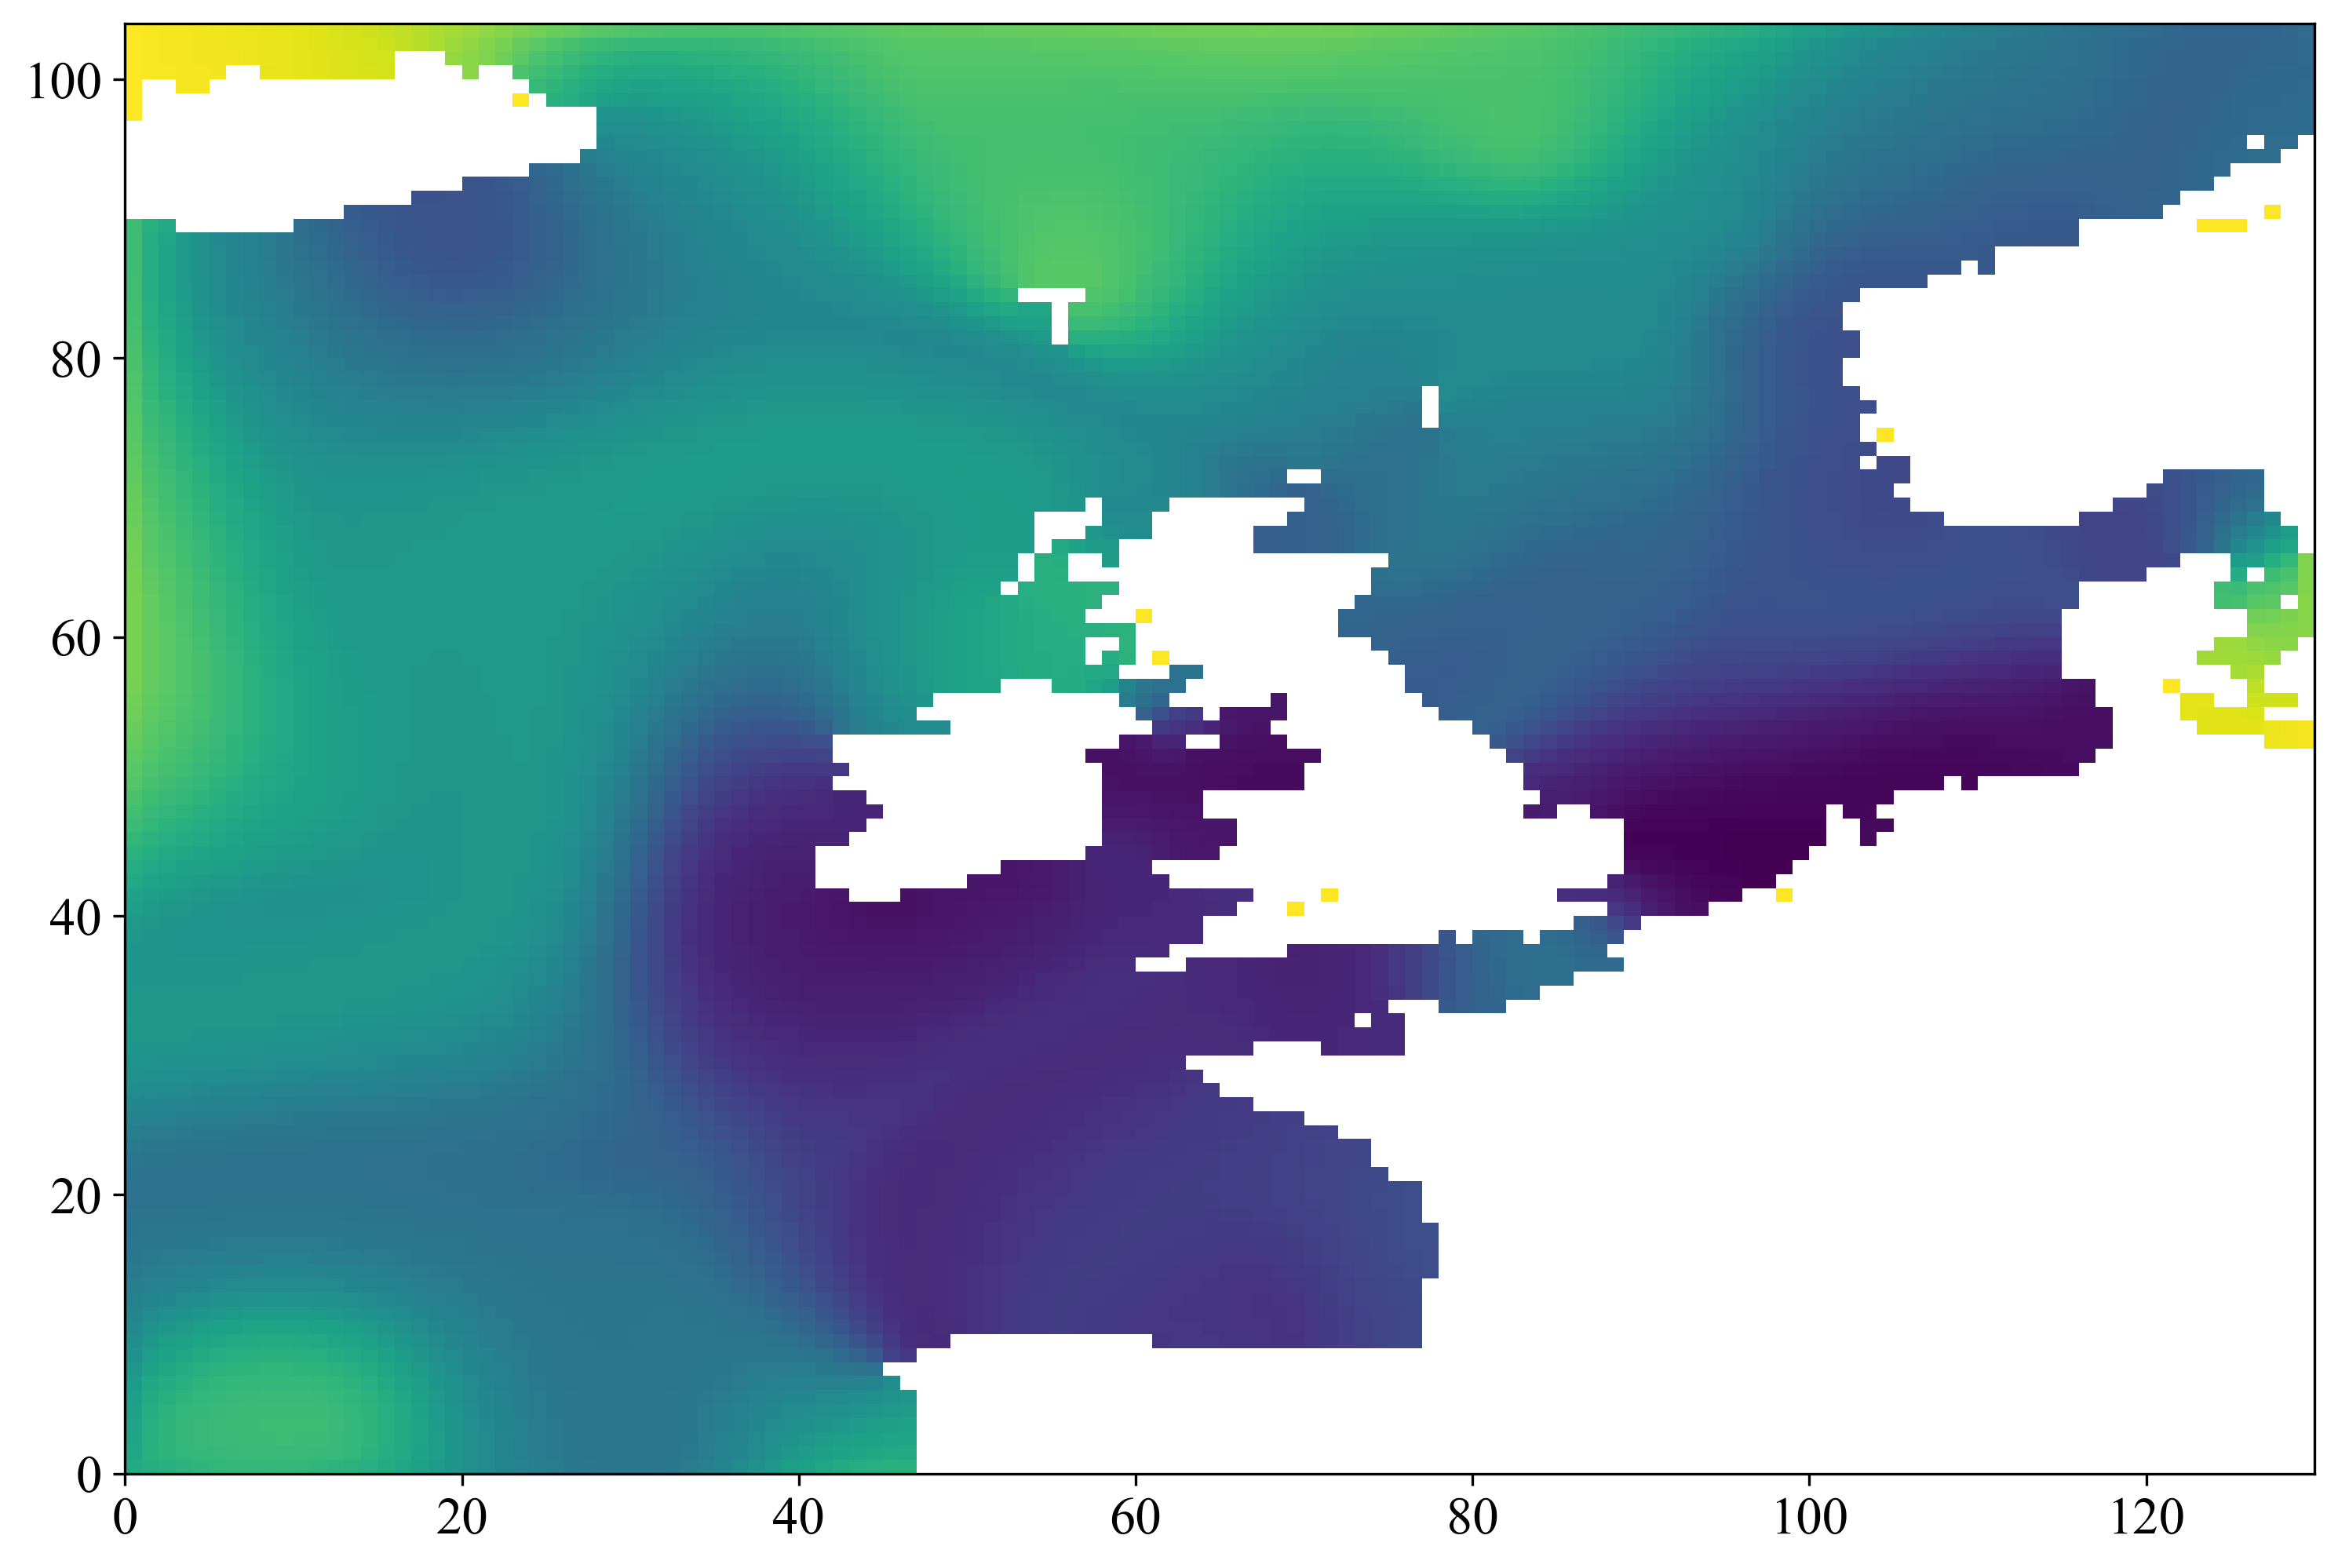

PyObject <matplotlib.collections.QuadMesh object at 0x7f57c3322190>

In [67]:
plt.pcolormesh(emapm1[:,:,1]')